In [188]:
import torch
import torch.nn as nn
import torchvision.datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances as pairwise_distances
import sklearn
from Generative_model import *

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 9)

# MNIST Interpolation

## Importing MNIST data

In [3]:
# Set parameters
batch_size_train = 128
batch_size_test = 32
epochs = 20
lr = 1e-3

In [4]:
# Defining the transformation (convert to tensor and normalize)
transform = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor()])
# Load Training data
trainloader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/',
                                                                     train=True, 
                                                                     download=True, 
                                                                     transform=transform), 
                                                                     batch_size=batch_size_train, shuffle=True)
# Load Testing data
testloader = torch.utils.data.DataLoader(torchvision.datasets.MNIST('/files/', 
                                                                    train=False, download=True, 
                                                                    transform=transform), 
                                                                    batch_size=batch_size_test, shuffle=True)

## Data Exploration

In [5]:
# Overview of data dimensions (how to access it)
dims_training = trainloader.dataset.data.shape
dims_testing = testloader.dataset.data.shape

print(f'There are {dims_training[0]} samples with a dimension of {dims_training[1]}x{dims_training[2]} (Training Set).')
print(f'There are {dims_testing[0]} samples with a dimension of {dims_testing[1]}x{dims_testing[2]} (Testing Set).')

There are 60000 samples with a dimension of 28x28 (Training Set).
There are 10000 samples with a dimension of 28x28 (Testing Set).


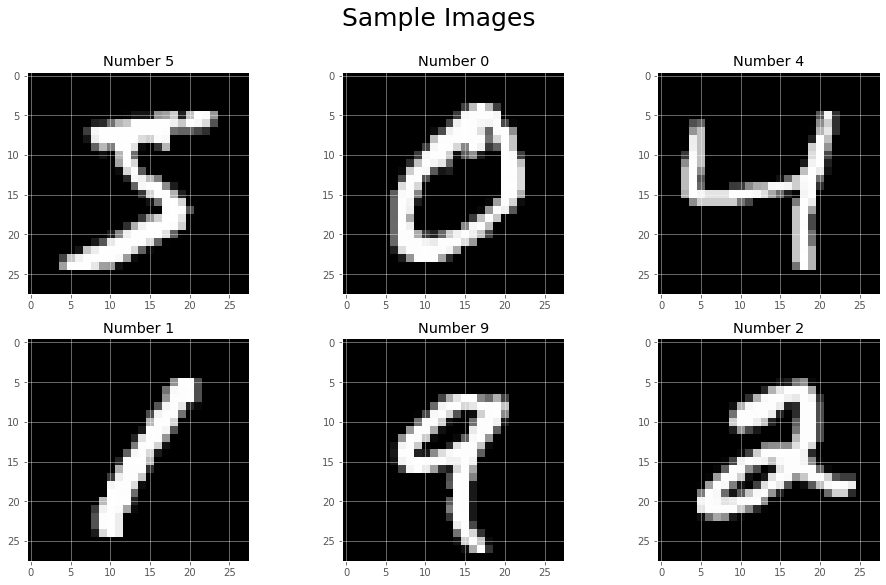

In [157]:
# Creating subplot
fig, axs = plt.subplots(2, 3)
plt.suptitle('Sample Images', fontsize=25)
axs = axs.ravel() # unravel so it is easier in for loop
color_map = plt.cm.get_cmap('Greys')

# Plotting first 6 images
for i in range(6):
    
    # Access image and label
    image = trainloader.dataset.data[i]
    label = trainloader.dataset.targets[i]
    
    # Plot
    axs[i].imshow(image, cmap=color_map.reversed())
    axs[i].grid(True, color='white', alpha=0.5)
    axs[i].set_title(f'Number {label}')

## Model

In [7]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
net = Net(input_shape=28*28).to(device)

# Set model optimizer and loss function
optimizer = optim.Adam(net.parameters(), lr=lr)
criterion = nn.MSELoss()

In [8]:
total_loss = []
for i, epoch in enumerate(np.arange(epochs)):

    # Running Loss
    loss = 0
    for batch_images, _ in trainloader:

        # Reshape images to be [N, 784] matrix (N = batch size)
        inputs = batch_images.view(-1, 28*28).to(device)

        # Zero Gradients for each batch
        optimizer.zero_grad()

        # Pass through autoencoder
        reconstructed = net(inputs)

        # Compute Loss, backprop, and update weights
        loss_val = criterion(reconstructed, inputs)
        loss_val.backward()
        optimizer.step()

        # Add batch loss
        loss += loss_val.item()

    # Compute epoch loss
    total_loss.append(loss / len(trainloader))
    print(f'Epoch: {epoch + 1} | Loss: {total_loss[i]:0.3f} (MSE)')

Epoch: 1 | Loss: 0.039 (MSE)
Epoch: 2 | Loss: 0.022 (MSE)
Epoch: 3 | Loss: 0.019 (MSE)
Epoch: 4 | Loss: 0.017 (MSE)
Epoch: 5 | Loss: 0.016 (MSE)
Epoch: 6 | Loss: 0.015 (MSE)
Epoch: 7 | Loss: 0.015 (MSE)
Epoch: 8 | Loss: 0.014 (MSE)
Epoch: 9 | Loss: 0.014 (MSE)
Epoch: 10 | Loss: 0.014 (MSE)
Epoch: 11 | Loss: 0.014 (MSE)
Epoch: 12 | Loss: 0.013 (MSE)
Epoch: 13 | Loss: 0.013 (MSE)
Epoch: 14 | Loss: 0.013 (MSE)
Epoch: 15 | Loss: 0.013 (MSE)
Epoch: 16 | Loss: 0.013 (MSE)
Epoch: 17 | Loss: 0.013 (MSE)
Epoch: 18 | Loss: 0.013 (MSE)
Epoch: 19 | Loss: 0.012 (MSE)
Epoch: 20 | Loss: 0.012 (MSE)


In [332]:
# Set to evaluate mode to fix model
net.eval()

# Pick random image to test network
idx = 6
img = testloader.dataset.data[idx]
img_f = img.view(-1, 28*28)
reconstucted_image = net(img_f.float())
reconstucted_image = reconstucted_image.view(28, 28).detach().numpy()

# Increase Contrast of image
reconstucted_image[reconstucted_image < 0] = 0
reconstucted_image = reconstucted_image*10

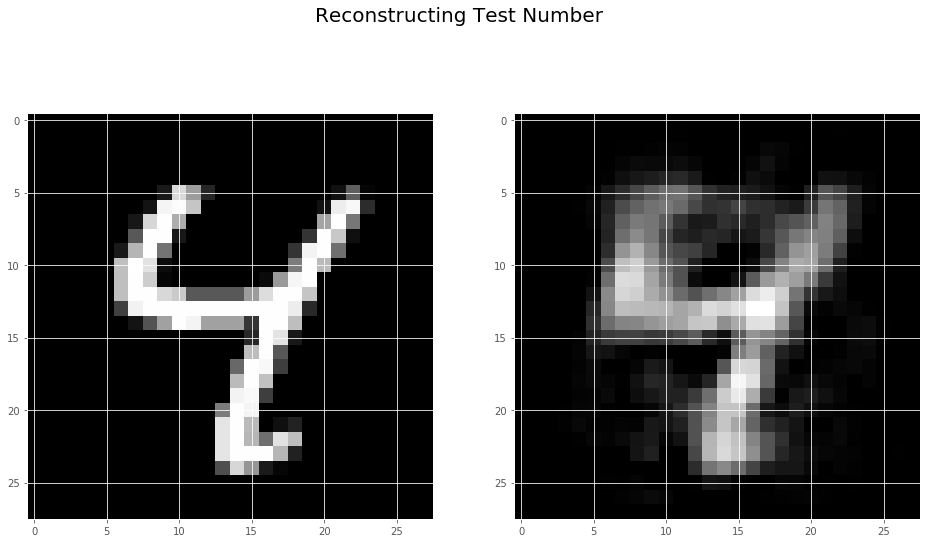

In [333]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.suptitle('Reconstructing Test Number', fontsize=20)
ax1.imshow(img, cmap=color_map.reversed())
ax2.imshow(reconstucted_image, cmap=color_map.reversed())

## Interpolation

In [334]:
# Pick two classes
c1 = 7
c2 = 2

# Select all samples that are within the class
A = testloader.dataset.data[testloader.dataset.targets == c1]
B = testloader.dataset.data[testloader.dataset.targets == c2]

print(f'There are {A.shape[0]} samples in class {c1} and {B.shape[0]} samples in class {c2}.')

There are 1028 samples in class 7 and 1032 samples in class 2.


In [335]:
# Flatten into [BATCH SIZE, 28*28]
A = A.view(-1, 28*28)
B = B.view(-1, 28*28)

# Encode all zeros and ones into the latent space
encoded_A = net.encoder(A.float()).detach().numpy()
encoded_B = net.encoder(B.float()).detach().numpy()

In [336]:
def interpolate_sample(x_0, int_vec, a):

    # Convex combinaton from starting point along interpolated vector to other class
    combined = a*int_vec + x_0

    # Convert to tensor and then pass through network to reconstruct
    combined = torch.tensor(combined)
    decoded_interpolated_img = net.decoder(combined)

    return decoded_interpolated_img
def process_image(image, c):

    # Deflatten reconstructed image
    image = image.view(28, 28).detach().numpy()

    # Clip any negative values and increase magnitude by factor of c
    image[image < 0] = 0
    image = image*c

    return image

In [337]:
# Take the mean/centroid vector of all encoded zeros and ones
A_centroid = np.mean(encoded_A, axis=0)
B_centroid = np.mean(encoded_B, axis=0)
A_to_B = B_centroid - A_centroid

# Create an array for convex combination constant a
a_arr = np.linspace(0, 1, num=11)

# original latent image
A_0 = encoded_A[0]

# constrast constant (to increase clarity in reconstructed image)
c = 10

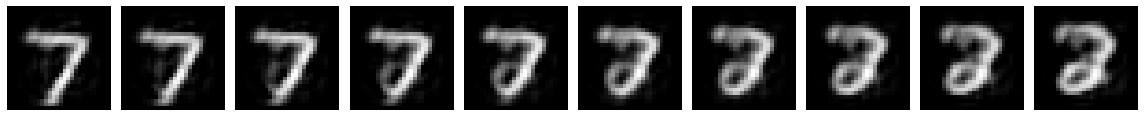

In [338]:
# Plotting translation from classes
fig, axs = plt.subplots(1,10)
axs = axs.ravel()

# For each convex combination constant
for i in range(10):
    a = a_arr[i]

    # Get reconstructed interpolated sample and process image
    image_vec = interpolate_sample(A_0, A_to_B, a)
    image = process_image(image_vec, c)

    # Plotting
    axs[i].imshow(image, cmap=color_map.reversed())
    axs[i].axis('off')
fig.tight_layout()

In the future, I plan on explorating translating classes and using geodesics instead of linear interpolation.

## Latent Space Exploration

In [339]:
print(f'Encoded Class A dimensions: {encoded_A.shape}.')
print(f'Hence, in the latent space, we have {encoded_A.shape[0]} samples in R^{encoded_A.shape[1]}.')

Encoded Class A dimensions: (1028, 32).
Hence, in the latent space, we have 1028 samples in R^32.


We can use this information to determine if the manifold for this particular class in Euclidean or not. We will do this with Classical Multidimensional-Scaling (cMDS).

----
*NOTE:The significance of cMDS is that we can determine if our interpolation methods would benefit with the use of harnessing non-Euclidean interpolation methods such as geodesics. That means if our encoded manifolds are in fact Euclidean, then there is no use in using geodesics.*

----
Given a distance matrix $D = (d_{ij})$, MDS tries to find a vector $x_1, x_2, \cdots, x_n \in \mathbb{R}^p$ such that
\begin{equation}
d_{ij} \approx \Vert x_i - x_j \Vert_2
\end{equation}
as close as possible.

Now, if our space is Euclidean, then there exists an exact configuration such that $d_{ij} = \Vert x_i - x_j \Vert_2$. If there exist no configuration, then we say the space is non-Euclidean.

Furthermore, we know if there exist a configuration, then we can simply shift our vector as a linear combination that also satisfies the constraint. Thus, cMDS takes this into account and finds the "centered configured". This is done by finding the centering matrix:
\begin{equation}
C = I_{n \times n} - \frac{1}{n} \mathbb{1}_{n \times n}
\end{equation}
where $I$ is the identity and $1$ is the ones matrix.

Then, we apply it to our distance matrix to find $B$
\begin{equation}
B = -\frac{1}{2}CDD^{T}C
\end{equation}

Lastly, we can use eigenvalue decomposition on $B$ to determine if there exist a configuration; negative eigenvalues signify that no such configuration exist. Moreover, a more negative eigenvalue in magnitude represents even more of a non-Euclidean space.

In [340]:
def cMDS_eig(D):
    '''
    Returns ALL eigenvalues, not just postive and top m ones...
    '''
    n = D.shape[0]

    # centering matrix
    C = np.eye(n) - (1/n)*np.ones((n, n))

    # Double Centering 
    B = -0.5*C @ D**2 @ C

    # Finding eigenvalues
    eigenvalues, _ = np.linalg.eig(B)

    return eigenvalues

In [341]:
# Euclidean pairwise norms
D_a = pairwise_distances(encoded_A)
D_b = pairwise_distances(encoded_B)

In [342]:
# Applying classical MDS to find all eigenvalues
eigenvalues_a = cMDS_eig(D_a)
eigenvalues_b = cMDS_eig(D_b)

Text(0.5, 0, 'Eigenvalue #')

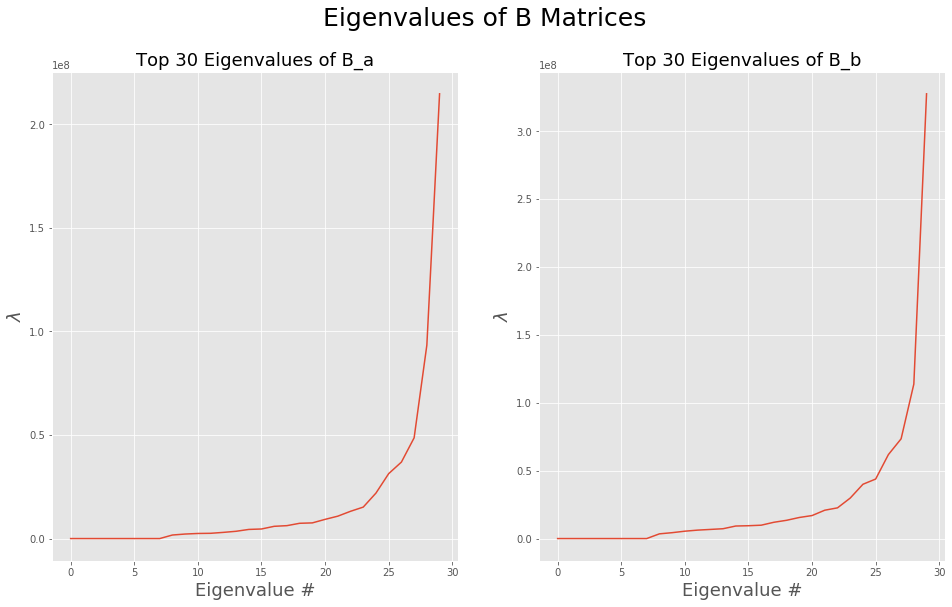

In [343]:
# Selecting top m eigenvalues
m = 30

# Plotting eigenvalues of classes
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.suptitle('Eigenvalues of B Matrices', fontsize=25)

# Class A
ax1.plot(np.arange(m), np.sort(eigenvalues_a)[-m:])
ax1.set_title(f'Top {m} Eigenvalues of B_a', fontsize=18)
ax1.set_ylabel(r'$\lambda$', fontsize=18)
ax1.set_xlabel('Eigenvalue #', fontsize=18)

# Class B
ax2.plot(np.arange(m), np.sort(eigenvalues_b)[-m:])
ax2.set_title(f'Top {m} Eigenvalues of B_b', fontsize=18)
ax2.set_ylabel(r'$\lambda$', fontsize=18)
ax2.set_xlabel('Eigenvalue #', fontsize=18)

It appears our classes A and B have no negative eigenvalues, which would imply a Euclidean spanned space. Let us confirm this.

In [344]:
print(f'Does the first class have any negative eigenvalues? {eigenvalues_a.any() < 0}.')
print(f'Does the second class have any negative eigenvalues? {eigenvalues_b.any() < 0}.')

Does the first class have any negative eigenvalues? False.
Does the second class have any negative eigenvalues? False.


In [345]:
# Circular distances (non-euclidean)
D_test = np.array([[0, 3.1416, 0.7854, 1.5708],
                    [3.1416, 0, 2.3562, 1.5708],
                    [0.7854, 2.3562, 0, 2.3562],
                    [1.5708, 1.5708, 2.3562, 0]])

In [346]:
# Classical MDS for all eigenvalues
eigenvalues_d_test = cMDS_eig(D_test)

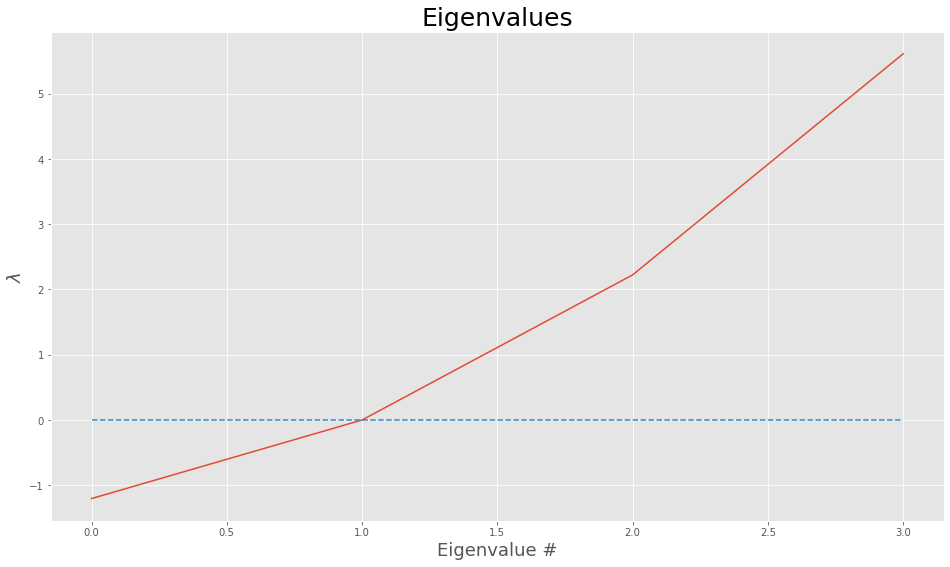

In [347]:
# Plotting
plt.title('Eigenvalues', fontsize=25)
plt.ylabel(r'$\lambda$', fontsize=18)
plt.xlabel('Eigenvalue #', fontsize=18)
plt.plot(np.arange(eigenvalues_d_test.shape[0]), np.sort(eigenvalues_d_test))
plt.plot(np.arange(eigenvalues_d_test.shape[0]), np.repeat(0, eigenvalues_d_test.shape[0]), ls='--')

In [348]:
e_values = np.round(eigenvalues_d_test, decimals=4)
print(f'Eigenvalues of circular distances: {e_values}.')

Eigenvalues of circular distances: [ 5.6117 -1.204  -0.      2.2234].


Since there exist a negative eigenvalue, we can conclude that D_test has non-Euclidean geometry. 